<a href="https://colab.research.google.com/github/hanyoseob/lecture_optimization/blob/main/chapter08_Newton's_method_for_natural_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method)
---
>In numerical analysis, ___Newton's method___, also known as the ___Newton–Raphson method___, named after Isaac Newton and Joseph Raphson, is __a root-finding algorithm__ which produces successively better approximations to the roots (or zeroes) of a real-valued function. The most basic version starts with a single-variable function $f$ defined for a real variable $x$, the function's derivative $f'$, and an initial guess $x_0$ for a root of $f$.
>
>>![newton's method](https://upload.wikimedia.org/wikipedia/commons/d/da/Newton_optimization_vs_grad_descent.svg "")
>>__[FIGURE] A comparison of [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) (green) and [Newton's method]((https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)) (red) for minimizing a function (with small step sizes). Newton's method uses curvature information (i.e. the second derivative) to take a more direct route.__
>
>__Before following an implementation below, PLEASE REVIEW MATHMETICAL DSCRIPTION[$^{[1]}$](https://en.wikipedia.org/wiki/Newton%27s_method)$^,$ [$^{[2]}$](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) since the more details are described HERE[$^{[1]}$](https://en.wikipedia.org/wiki/Newton%27s_method)$^,$ [$^{[2]}$](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization).__

---
In [the previous chapter](https://colab.research.google.com/drive/1KZ6mFmlUndOF05QFRAq2pE_lxwjMp684?usp=sharing), I implemented [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) to solve a 1D toy-examples.

However, in this chapter we will cover a ___deblurring problem___ (called ___image enhancement___), the same task solved with [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) in [the previous chapter](https://colab.research.google.com/drive/1mElbDh90g5zsMDAyNvJna7y4dg8xrh_0?usp=sharing).

Here, we will implement ___a deblurring method___ using [the Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method) from the Gaussian-blurred image illustrated in [the chapter. 1](https://colab.research.google.com/drive/1YGiAGcZOhsmfqc568LOpweJHmGCSviWD?usp=sharing).

Its optimization problem is formulated as:

> $x^* = \arg \min_{x} F(x)$,

where a fidelity term $F(x)$ is defined as $\frac{1}{2} || Ax - y ||_2^2$, a system matrix $A$ denotes 2D convolution operation with Gaussian kernel, $y$ is blurry image from the system matrix $A$, and $x$ is a deblurred image.

In the optimization problem above, since $F(x) = \frac{1}{2} || Ax - y ||_2^2$ is a convex function, the optimal solution $x^*$ is the point $x$ where its derivative $\nabla F(x)= A^T(Ax - y)$ satisfies zero. In terms of [the newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), $f(x)$ which is the function trying to find the roots ( or zeros ), can be formulated by the derivative $\nabla F(x)= A^T(Ax - y)$. Therefore, $f'(x)$ is defined as $A^TA$.

Specifically, we need to define a transopose operator $A^T$ of the 2D convolution operation. The answer that ___How to define the transpose operator of the function___ is described [MY OTHER LECTURE](https://www.youtube.com/watch?v=erdPhFEoFYc). Please watch [THE LECTURE](https://www.youtube.com/watch?v=erdPhFEoFYc) before starting the example.

## General solution
---
> $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$,

where $f(\cdot)$ and $f'(\cdot)$ are the function trying to find the roots ( or zeros ) and its derivative, respectively.


# Implementation
---

1. Problem definition
7. Implement the newton's method to estimate a deblurred image

## Step 1. Problem definition

1. Objective function $F(x)$
> $F(x) = \frac{1}{2} || Ax - y ||_2^2$

2. the function trying to find the roots $f(x)$ ( = its derivative $\nabla F(x)$ )
> $f(x) = \nabla F(x)$
>
> $~~~~~~~= A^T(Ax - y)$

3. its derivative $f'(x)$
> $f'(x) = A^TA$

3. Global solution

  > $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$,

  > $x_{n+1} = x_n - \frac{A^T(Ax_n - y)}{A^TA}$


## Step 2. Newton's method

1. Add packages
2. Define 2D [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)
3. Set the system matrix $A$ and its [transpose](https://en.wikipedia.org/wiki/Transpose) $A^T$
4. Set the parameters of the Newton's method
5. Run the Newton's method

### Add packages

In [ ]:
# Mathmetical packages
import numpy as np
from scipy.signal import convolve

# Image processing package
from skimage import data
from skimage.transform import resize

# Metrics calculating packages
from skimage.metrics import normalized_root_mse as compare_nmse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ploting packages
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# Ploting options
font = {'family': 'normal',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)


### Define [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)

> $f(x, y) = A \exp \left( -{\left( {\frac{(x - x_0)^2}{2\sigma_X^2}} + {\frac{(y - y_0)^2}{2\sigma_Y^2}} \right)} \right),$

where $A$ is the amplitude, $x_0$ and $y_0$ are the center positions, $\sigma_X$ and $\sigma_Y$ are the standard deviations.

In [ ]:
def gaus2d(nx, ny, x0=0, y0=0, sgmx=3, sgmy=3, A=1):
  x = np.linspace(-nx/2, nx/2, nx)
  y = np.linspace(-ny/2, ny/2, ny)
  x, y = np.meshgrid(x, y)

  ker = A * np.exp(-(0.5*((x - x0)/sgmx)**2 + 0.5*((y - y0)/sgmy)**2))
  ker = ker / np.sum(ker)

  return ker


### Set the system matrix $A$ and its transpose $A^T$

__If you are not familiar with the concept of the transpose, please check out [my lecture video related to transpose](https://www.youtube.com/watch?v=erdPhFEoFYc) and [wikipedia](https://en.wikipedia.org/wiki/Transpose).__ 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


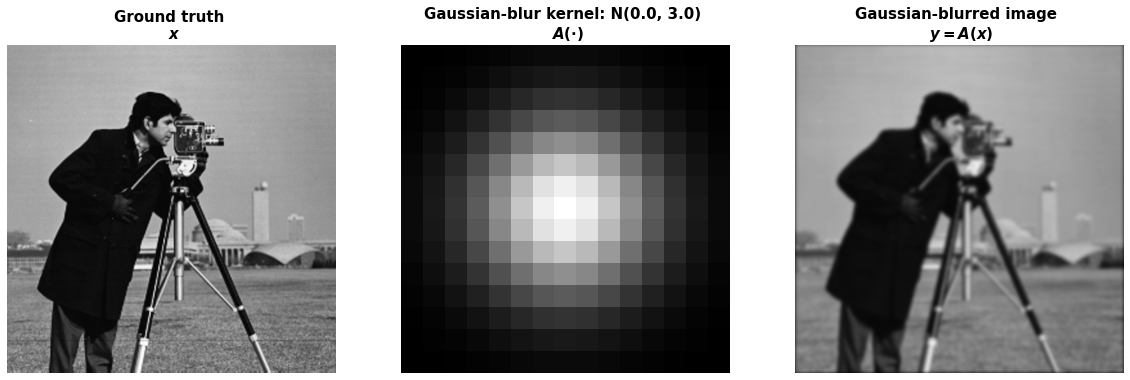

Result from Gaussian-blurred
NSME: 1.1977e-01
PSNR: 24.0498
SSIM: 0.8574
 


In [ ]:
# Load the clean image x ( = ground truth ) 
N = 512   # number of rows for the image
M = 512   # number of colums for the image

x_gt = data.camera().astype(dtype=np.float64)/255.0
x_gt = resize(x_gt, output_shape=(N, M))

# Generate Gaussian kernel A
K = 15    # size of the Gaussian kernel (*the size of kernel must be matched with 'ODD NUMBER'.)
MEAN = 0  # mean of Gaussian kernel
SGM = 3   # standard deviation of Gaussian kernel

ker = gaus2d(K, K, x0=MEAN, y0=MEAN, sgmx=SGM, sgmy=SGM)

# Define the System operator (A) and its transpose (AT)
# A: Convolution operation with Gaussian kernel
# AT: Convolution operation with fliped Gaussian kernel
A = lambda x: convolve(x, ker, mode='same')
AT = lambda y: convolve(y, np.flip(np.flip(ker, axis=0), axis=1), mode='same')

# Generate the output y from the system operator A
y = A(x_gt)


# Plot the images
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

axs[0].imshow(x_gt, vmin=0, vmax=1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Ground truth \n $x$', fontsize=15, fontweight='bold')

axs[1].imshow(ker, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Gaussian-blur kernel: N(%.1f, %.1f) \n $A( \cdot )$' % (MEAN, SGM), fontsize=15, fontweight='bold')

axs[2].imshow(y, vmin=0, vmax=1, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Gaussian-blurred image \n $y = A(x)$', fontsize=15, fontweight='bold')

plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_gaus = y

nmse_gaus = compare_nmse(x_gt, x_gaus)
psnr_gaus = compare_psnr(x_gt, x_gaus)
ssim_gaus = compare_ssim(x_gt, x_gaus)

print('Result from Gaussian-blurred')
print('NSME: %.4e' % nmse_gaus)
print('PSNR: %.4f' % psnr_gaus)
print('SSIM: %.4f' % ssim_gaus)
print(' ')

### Set the parameters of the Newton's method

In [ ]:
# F: Objective function

# f: The function trying to find the roots ( or zeros ) ( = dF )
# df: Its derivative

F = lambda x: 1/2 * np.sum( (A(x) - y) ** 2 ) ** 1/2
f = lambda x: AT( A(x) - y )
df = lambda x: AT( A(np.ones_like(x)) )

# Hyper parameters for the gradient descent method
max_iter = 300

### Run the Newton's method

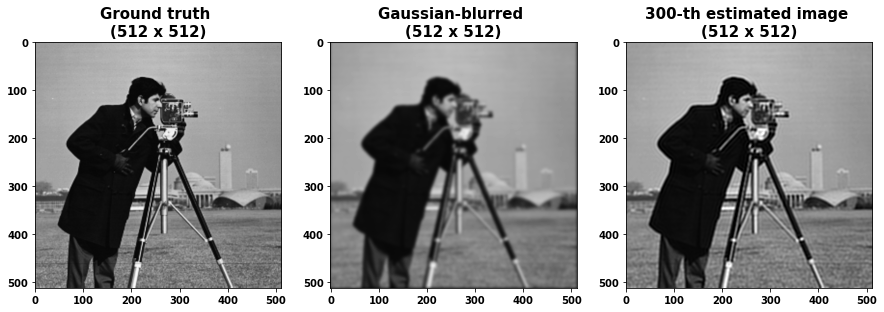

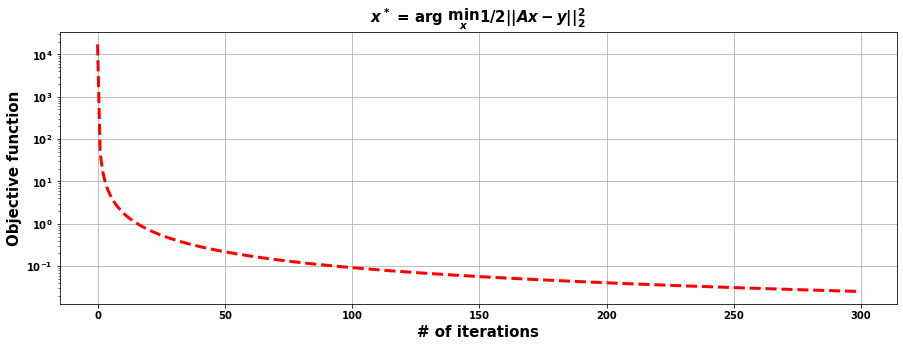

Result from Newton's method
NSME: 6.0153e-02
PSNR: 30.0313
SSIM: 0.9429


In [ ]:
x = np.zeros((N, M))

x_iter = []
y_iter = []

x_iter.append(x)
y_iter.append(F(x))

for i in range(1, max_iter + 1):

  # Newton's method
  x = x - f(x) / df(x)

  x_iter.append(x)
  y_iter.append(F(x))

  # Plot the results from gradient descent method
  if ((i + 1) % 10) == 0 or (i + 1) == max_iter:
    # Plot the images from ground truth, gradient descent method, and difference map.
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    ax = axs[0]
    pcm = ax.imshow(x_gt, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Ground truth \n(%d x %d)' % (N, M), fontsize=15, fontweight='bold')
    # fig.colorbar(pcm, ax=ax)

    ax = axs[1]
    pcm = ax.imshow(y, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Gaussian-blurred \n(%d x %d)' % (N, M), fontsize=15, fontweight='bold')
    # fig.colorbar(pcm, ax=ax)

    ax = axs[2]
    pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
    ax.set_title('%d-th estimated image \n(%d x %d)' % (i + 1, N, M), fontsize=15, fontweight='bold')
    # fig.colorbar(pcm, ax=ax)

    # Plot a curve of the objective function
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

    axs.semilogy(y_iter, 'r--', linewidth=3)
    axs.grid(True)
    axs.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
    axs.set_ylabel('Objective function', fontsize=15, fontweight='bold')
    axs.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

    display.clear_output(wait=True)
    plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_est_newton = x

nmse_newton = compare_nmse(x_gt, x_est_newton)
psnr_newton = compare_psnr(x_gt, x_est_newton)
ssim_newton = compare_ssim(x_gt, x_est_newton)

print('Result from Newton\'s method')
print('NSME: %.4e' % nmse_newton)
print('PSNR: %.4f' % psnr_newton)
print('SSIM: %.4f' % ssim_newton)

# Conclusion

In this chapter, we covered ___the deblurring problem___, which is the ___realistic___ and ___practical___ problems in a natural image processing. Below figure shows the results from [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function) and [the newton's method](https://en.wikipedia.org/wiki/Newton%27s_method). [The newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) provides an enhanced image and its quantitative metrics are significantly improved than the Gaussian-blurred image.

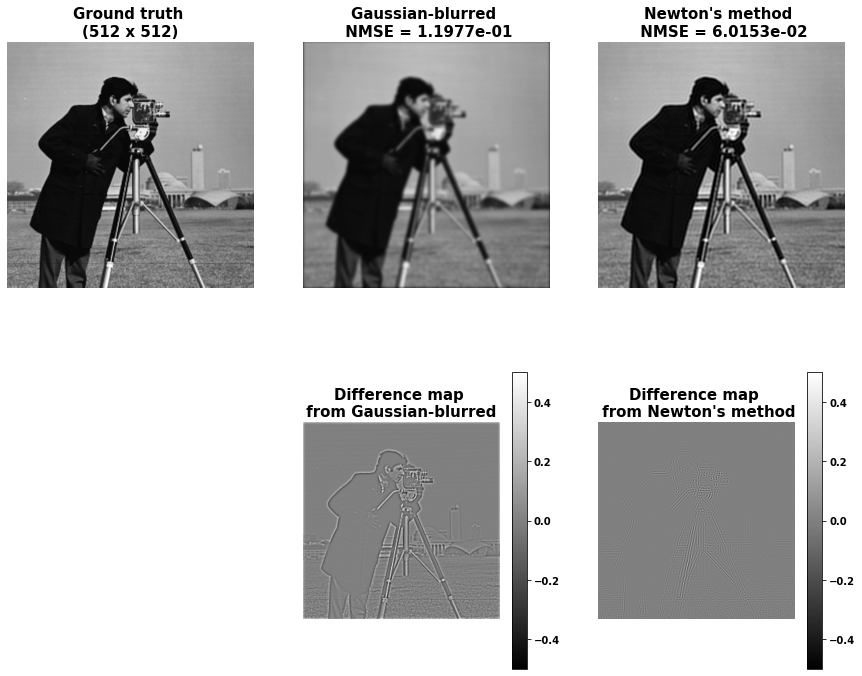

 
Quantitative metrics
 
Normalized Mean Sqaure Error (NMSE)
Gaussian-blurred image : 1.1977e-01
Newton's method        : 6.0153e-02
 
Peak Signal to Noise Ratio (PSNR)
Gaussian-blurred image : 24.0498
Newton's method        : 30.0313
 
Structural Similarity Index Measure (SSIM)
Gaussian-blurred image : 0.8574
Newton's method        : 0.9429
 


In [ ]:
# Plot the results
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))

ax = axs[0, 0]
pcm = ax.imshow(x_gt, cmap='gray', vmin=0, vmax=1)
ax.set_title('Ground truth \n(%d x %d)' % (N, M), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[0, 1]
pcm = ax.imshow(x_gaus, cmap='gray', vmin=0, vmax=1)
ax.set_title('Gaussian-blurred \n NMSE = %.4e' % (nmse_gaus), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[0, 2]
pcm = ax.imshow(x_est_newton, cmap='gray', vmin=0, vmax=1)
ax.set_title('Newton\'s method \n NMSE = %.4e' % (nmse_newton), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[1, 0]
ax.axis('off')

ax = axs[1, 1]
pcm = ax.imshow(x_gt - x_gaus, cmap='gray', vmin=-0.5, vmax=+0.5)
ax.set_title('Difference map \n from Gaussian-blurred ', fontsize=15, fontweight='bold')
ax.axis('off')
fig.colorbar(pcm, ax=ax)

ax = axs[1, 2]
pcm = ax.imshow(x_gt - x_est_newton, cmap='gray', vmin=-0.5, vmax=+0.5)
ax.set_title('Difference map \n from Newton\'s method', fontsize=15, fontweight='bold')
ax.axis('off')
fig.colorbar(pcm, ax=ax)

plt.show()

# Print the quantitative metrics
print(' ')
print('Quantitative metrics')
print(' ')

print('Normalized Mean Sqaure Error (NMSE)')
print('Gaussian-blurred image : %.4e' % nmse_gaus)
print('Newton\'s method        : %.4e'% nmse_newton)
print(' ')

print('Peak Signal to Noise Ratio (PSNR)')
print('Gaussian-blurred image : %.4f' % psnr_gaus)
print('Newton\'s method        : %.4f'% psnr_newton)
print(' ')

print('Structural Similarity Index Measure (SSIM)')
print('Gaussian-blurred image : %.4f' % ssim_gaus)
print('Newton\'s method        : %.4f'% ssim_newton)
print(' ')

#References
---

1. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
2. [Newton's method in optimization](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)
3. [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)

# Next
---

Next chapter, we will implement [the newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) to cover a medical image processing like computed tomography (CT).